<a href="https://colab.research.google.com/github/ekakurnia/CNN-DeepLearning/blob/master/Covid19_TransferLearning100Epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd "/content/drive/My Drive/DatasetCovid-19"

/content/drive/My Drive/DatasetCovid-19


In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np
import pickle
import cv2
import keras

from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model
from keras.layers import BatchNormalization

from os import listdir
from keras import backend as K
from keras.layers import Input
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


Using TensorFlow backend.


In [0]:
EPOCHS = 100
INIT_LR = 1e-3
BS = 4
default_image_size = tuple((256, 256))
image_size = 0
directory_root = "/content/drive/My Drive/DatasetCovid-19"
width=256
height=256
depth=3

In [0]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [0]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".jpeg") == True or image_directory.endswith(".png") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    %time print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing covid ...
[INFO] Processing normal ...
Error : [Errno 20] Not a directory: '/content/drive/My Drive/DatasetCovid-19/cnn_model.pkl'


In [0]:
image_size = len(image_list)

In [0]:
print(image_size)

148


In [0]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [0]:
print(label_binarizer.classes_)

['covid' 'normal']


In [0]:
label = []
for i in image_labels:
    if i == [0]:
       label.append([1,0])
    else:
       label.append([0,1])
       
labels = np.array(label)      

In [0]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [0]:
print("[INFO] Spliting data to train, test, and validate")
x_train, x_test, y_train, y_test, = train_test_split(np_image_list, labels, test_size=0.2, random_state = 42)


[INFO] Spliting data to train, test, and validate


In [0]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [0]:
from keras.applications import InceptionResNetV2

conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(256,256,3))

219062272/219055592 [==============================] - 8s 0us/step


In [0]:
conv_base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 127, 127, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 127, 127, 32) 0           batch_normalization_1[0][0]      
________________________________________________________________________________

In [0]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))  #Sigmoid function at the end because we have just two classes

In [0]:
#Lets see our model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 6, 6, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 55296)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               14156032  
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 68,493,282
Trainable params: 68,432,738
Non-trainable params: 60,544
_________________________________________________________________


In [0]:
print('Number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('Number of trainable weights after freezing the conv base:', len(model.trainable_weights))

Number of trainable weights before freezing the conv base: 492
Number of trainable weights after freezing the conv base: 4


In [0]:
#We'll use the RMSprop optimizer with a learning rate of 0.0001
#We'll use binary_crossentropy loss because its a binary classification
from keras import optimizers

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

In [0]:
#Lets create the augmentation configuration
#This helps prevent overfitting, since we are using a small dataset
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

train_datagen = ImageDataGenerator(rescale=1./255,   #Scale the image between 0 and 1
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)  #We do not augment validation data. we only perform rescale


In [0]:
#Create the image generators
train_generator = train_datagen.flow(x_train, y_train, batch_size=BS)
val_generator = val_datagen.flow(x_test, y_test, batch_size=BS)

In [0]:
#The training part

history = model.fit_generator(train_generator,
                              steps_per_epoch=len(x_train) // BS,
                              epochs=EPOCHS,
                              validation_data=val_generator)

Epoch 1/100
29/29 [==============================] - 20s 681ms/step - loss: 0.6798 - acc: 0.6447 - val_loss: 0.8014 - val_acc: 0.5333
Epoch 2/100
29/29 [==============================] - 3s 90ms/step - loss: 0.4906 - acc: 0.8114 - val_loss: 0.7309 - val_acc: 0.5333
Epoch 3/100
29/29 [==============================] - 3s 89ms/step - loss: 0.6223 - acc: 0.7061 - val_loss: 0.7277 - val_acc: 0.5333
Epoch 4/100
29/29 [==============================] - 3s 89ms/step - loss: 0.4630 - acc: 0.8070 - val_loss: 0.6993 - val_acc: 0.5333
Epoch 5/100
29/29 [==============================] - 3s 88ms/step - loss: 0.5341 - acc: 0.7241 - val_loss: 0.4224 - val_acc: 0.5333
Epoch 6/100
29/29 [==============================] - 3s 88ms/step - loss: 0.3734 - acc: 0.8080 - val_loss: 0.5472 - val_acc: 0.5333
Epoch 7/100
29/29 [==============================] - 3s 89ms/step - loss: 0.3456 - acc: 0.8509 - val_loss: 0.7837 - val_acc: 0.5333
Epoch 8/100
29/29 [==============================] - 3s 92ms/step - loss: 

In [0]:
#Save the model
model.save_weights('model_wieghts.h5')
model.save('model_keras.h5')

In [0]:
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

30/30 [==============================] - 2s 53ms/step
Test Accuracy: 76.66666507720947


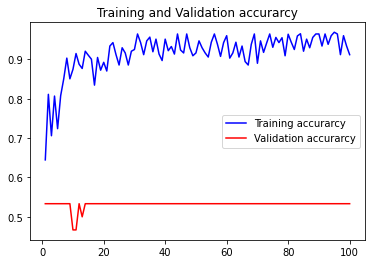

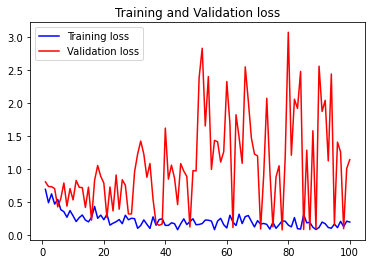

In [0]:
#lets plot the train and val curve
import matplotlib.pyplot as plt

#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure()

#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()